# 코드 작성완료
# 주석 미완료

In [49]:
import json
import math
import os
import urllib.request
import warnings #경고메세지 무시하는 라이브러리
from urllib.error import HTTPError

import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib_inline.backend_inline
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf") 
sns.set()

    os.environ - 환경변수 설정
    운영 체제에 설정되어있지 않은 환경변수를 사용할시 error발생
    에러 대신 'none'을 변환받고 싶을시엔 .get() 변수 사용

In [50]:
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/") # 환경변수 설정
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/Activation_Functions/") # 환경 변수

def set_seed(seed): # 특정 시드 설정
    np.random.seed(seed) 
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # gpu(cuda) 사용
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42) # 42번째 시드로 설정

torch.backends.cudnn.deterministic = True # deterministic = 결정론적 / 예측된 동작을 하는 기능
torch.backends.cudnn.benchmark = False # benchmark = 기준 / 기준에 맞춰진 동작을 하는 기능

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0") 
print("using device", device) # Gpu를 사용할 수 있을시엔 cuda:0 출력


using device cuda:0


In [51]:
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/" # 기존에 제작된 모델을 받기 위한 url지정

pretrained_files =  [ # 필요한 데이터 다운로드
    "FashionMNIST_elu.config",
    "FashionMNIST_elu.tar",
    "FashionMNIST_leakyrelu.config",
    "FashionMNIST_leakyrelu.tar",
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_swish.config",
    "FashionMNIST_swish.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar",
]

os.makedirs(CHECKPOINT_PATH, exist_ok=True) # 환경변수 생성

for file_name in pretrained_files: # 위에서 지정한 파일을 다운받기 위한 코드
    file_path = os.path.join(CHECKPOINT_PATH, file_name) # 파일 주소는 환경변수 및 파일 이름으로 지정
    if not os.path.isfile(file_path): 
        file_url = base_url + file_name # base url에서 파일 이름을 찾을 시 다운로드 시작
        print(f"Downoading{file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path) # 찾지 못할 시 에러코드 출력
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

In [52]:
class ActivationFunction(nn.Module): # 데이터 상속을 위한 모듈 지정
    def __init__(self): 
        super().__init__() # 데이터 상속
        self.name = self.__class__.__name__ # self.name은 nn.module에서 받은 이름 사용
        self.config = {"name": self.name} # 이를 self.config에 지정

In [53]:
class Sigmoid(ActivationFunction): # sigmoid class 지정, 상위 self 클래스를 부모 클래스로 지정
    def forward(self, x): # self와 x 호출
        return 1 / (1 + torch.exp(-x)) # 1+(임의 텐서의 -x제곱) 나누기 1

class Tanh(ActivationFunction): # Tanh 클래스 지정, 상위 self 클래스를 부모 클래스로 지정
    def forward(self, x): #self와 x 호출
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x) # x_exp와 neg_x_exp 지정
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp) # 위와 비슷한 수학 공식

In [54]:
class ReLU(ActivationFunction): # 지정되어있던 ActivationFunction 클래스를 ReLU에 지정 
    def forward(self, x):
        return x * (x > 0).float()

class LeakyReLU(ActivationFunction): # 지정되어있던 ActivationFunction 클래스를 약한ReLU에 지정 
    def __init__(self, alpha=0.1): # 일반 ReLU와 다른 약한 ReLU는 alpha에 0.1이라는 수를 대입 후 계산
        super().__init__()
        self.config["alpha"] = alpha

    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

class ELU(ActivationFunction): # 지정되어있던 ActivationFunction 클래스를 ELU에 지정 
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x) - 1)

class Swish(ActivationFunction): # 지정되어있던 ActivationFunction 클래스를 Swish에 지정 
    def forward(self, x):
        return x * torch.sigmoid(x)

In [55]:
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish} # 여러 class를 하나의 함수에 함축, 대 소문자 통합

In [56]:
def get_grads(act_fn, x): # get_grads에 act_fn, x 함수 호출로 기울기 계산
    """Computes the gradients of an activation function at specified positions.

    Args:
        act_fn: An object of the class "ActivationFunction" with an implemented forward pass.
        x: 1D input tensor.

    Returns:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_()
    out = act_fn(x)
    out.sum().backward()
    return x.grad

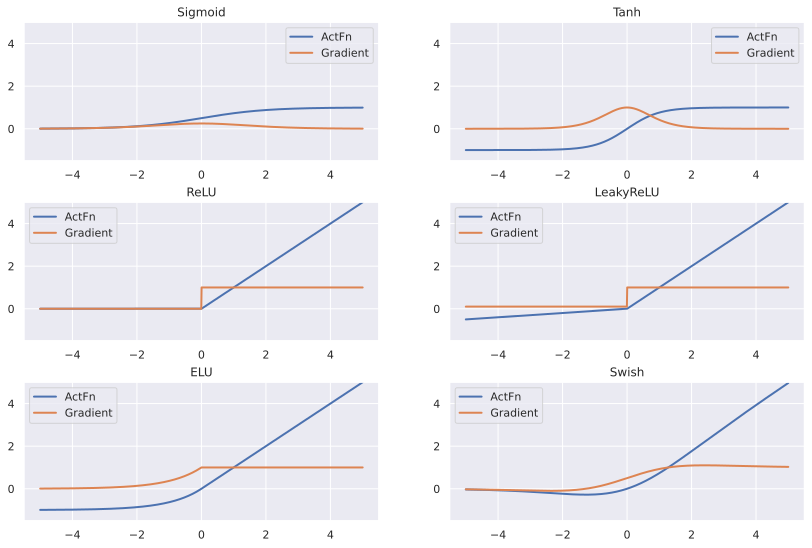

In [57]:
def vis_act_fn(act_fn, ax, x):
    # activation function 실행을 위한 설정 및 실행코드
    y = act_fn(x) 
    y_grads = get_grads(act_fn, x)
    # x, y, 그래디언트를 각각 cpu로 계산
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    # 도면 그리기 시작
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# activation function 삽입
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)

# 도면 그리기 시작
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3)) # 도면의 크기 결정 (커스터마이징 가능)
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i, cols)], x)
fig.subplots_adjust(hspace=0.3)
plt.show() # 기울기 도면 출력

# Analysing the effect of activation functions

In [58]:
class BaseNetwork(nn.Module): # github에 기제되어있는 nn,module 호출
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]): # 각 함수 및 계산식 저장
        """ Base Network.

    Args:
        act_fn: ObObject of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__() # nn. module 상속

        layers = [] # 설정되어있던 hidden_sizes를 기반으로 network 구축
        layer_sizes = [input_size] + hidden_sizes
        layer_size_last = layer_sizes[0]
        for layer_size in layer_sizes[1:]:
            layers += [nn.Linear(layer_size_last, layer_size), act_fn]
            layer_size_last = layer_size
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # 상위 코드를 Sequential 함수로 함축하고 layer에 지정
        self.layers = nn.Sequential(*layers)

        # 모델을 로드하고 저장하는 기능도 추가, 하이파라미더 '.json'파일로 저장
        self.config = {
            "act_fn": act_fn.config,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1) # 이미지 파일 재설정
        out = self.layers(x)
        return out

    훈련하기 위한 데이터 세트 = FashionMNIST 설정
    torchvision 사용 = 흔히 사용되는 데이터 세트, 모델 아키텍쳐 등을 포함한 이미지 변환 파일


In [59]:
def _get_config_file(model_path, model_name): # 하이퍼파라미터 저장은 '.config'파일로 저장
    return os.path.join(model_path, model_name + ".config")


def _get_model_file(model_path, model_name): # 네트워크 파라미터 저장은 '.tar'파일로 저장
    return os.path.join(model_path, model_name + ".tar")


def load_model(model_path, model_name, net=None):
    """Loads a saved model from disk. - 저장된 세이브 모델을 디스크(로컬)로부터 로딩

    Args: (전달인자)
        model_path: Path of the checkpoint directory 
        model_name: Name of the model (str)
        net: (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(
        config_file
    ), f'Could not find the config file "{config_file}". Are you sure this is the correct path and you have your model config stored here?'
    assert os.path.isfile(
        model_file
    ), f'Could not find the model file "{model_file}". Are you sure this is the correct path and you have your model stored here?'
    with open(config_file) as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net


def save_model(model, model_path, model_name):
    """Given a model, we save the state_dict and hyperparameters. - 모델이 제공될 시 state_dict와 하이퍼 파라미터를 저장

    Args:
        model: Network object to save parameters from
        model_path: Path of the checkpoint directory
        model_name: Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

In [60]:
# 이미지 파일 트랜스폼 적용후 텐서생성 -> -1 ~ 1 사이 범위에서 일반화
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])
# 훈련용 데이터 셋을 불러오고 
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
# 테스트용 세팅으로 준비
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [61]:
# 각 데이터 불러오기 및 사이즈 조정

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
test_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)

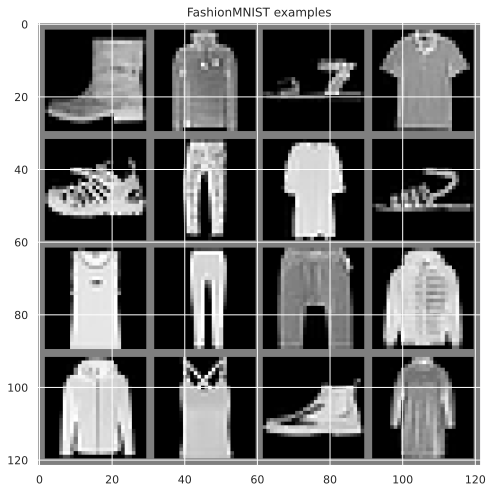

In [62]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# 데이터 로더 세트 시각화
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8)) # 8x8의 사이즈인 도표를 만들어준다.
plt.title("FashionMNIST examples") # title 생성
plt.imshow(img_grid) # img_grid 시각화 해준다.
plt.axis("on") # 도표의 축을 보여준다.
plt.show() # 도표를 그림으로 보여준다.
plt.close() # pyplot이 사용한 figure를 명시적으로 닫아 메모리를 절약

In [63]:
def visualize_gradients(net, color="C0"):
    """Visualize gradients. - 그래디언트 시각화 layer개수에 따른 각 활성화 함수의 그래프 차이 확인

    Args:
        net: Object of class BaseNetwork 
        color: Color in which we want to visualize the histogram (for easier separation of activation functions) 
    """
    net.eval() # 평가모드로 전환
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    net.zero_grad() # 모든 매개변수의 변화도 버퍼 0으로 설정
    preds = net(imgs) # imgs를 가지는 preds 함수 설정
    loss = F.cross_entropy(preds, labels) # imgs, labels 회기기능을 가지는 loss 함수 설정
    loss.backward() # loss함수 부터 역실행

    grads = {
        name: params.grad.data.view(-1).cpu().clone().numpy()
        for name, params in net.named_parameters()
        if "weight" in name
    }
    net.zero_grad() # 모든 매개변수의 변화도 버퍼 0으로 설정

    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5)) # 각 셀의 크기 설정
    fig_index = 0 # layer 0부터 시작
    for key in grads:
        key_ax = ax[fig_index % columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True) # 각 셀의 특성 설정
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude") # 각 셀이 가지게 될 서브 타이틀
        fig_index += 1 # layer마다 그래프 구하기
    fig.suptitle(
        f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05 # title 설정
    )
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

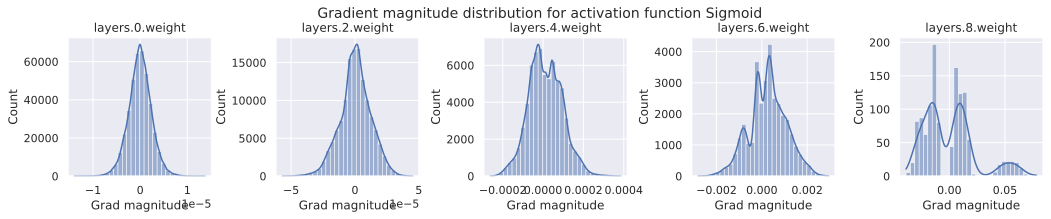

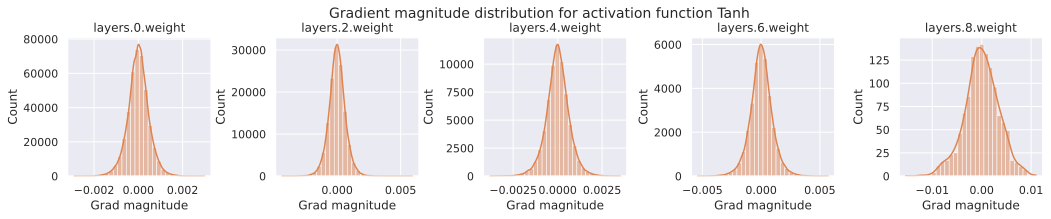

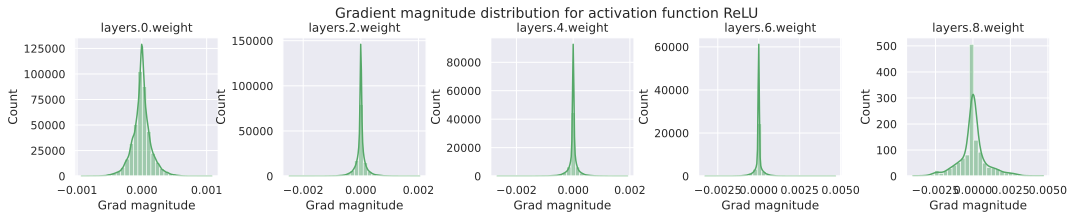

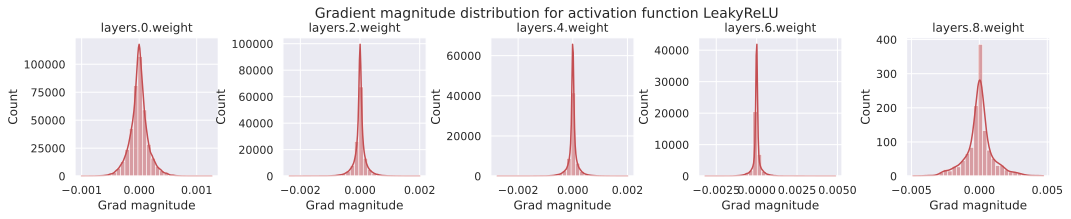

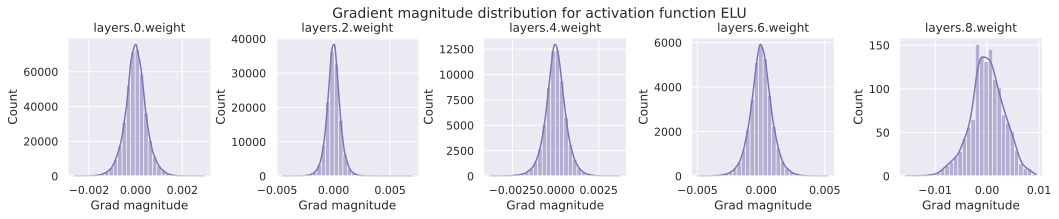

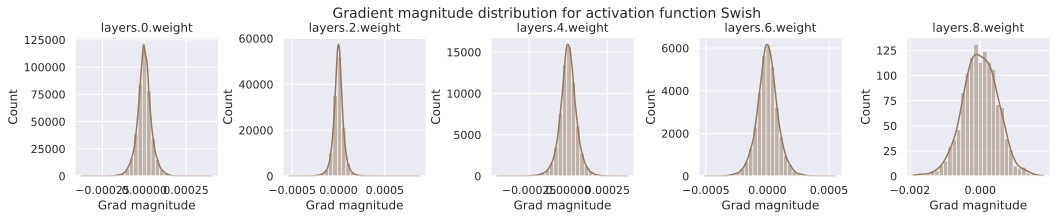

In [64]:
warnings.filterwarnings("ignore") # 경고문 무시하기

# 시각화 코드 실행
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # 일정한 값 출력을 위한 시드설정
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")

# Model-training
    훈련 루프 생성

In [65]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """Train a model on the training set of FashionMNIST. - FashionMNIST 훈련 세팅값을 이용한 훈련 시작

    Args:
        net: Object of BaseNetwork
        model_name: (str) Name of the model, used for creating the checkpoint names
        max_epochs: Number of epochs we want to (maximally) train for
        patience: If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size: Size of batches used in training
        overwrite: Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
        
        # 옵티마이저, loss, 로컬 데이터 로더 정의
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) 
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(
            train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True
        )

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ###########
            # 훈련시작 #
            ###########
            net.train()
            true_preds, count = 0.0, 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)  # To GPU
                optimizer.zero_grad() 
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step() # 훈련 하는 동안 쌓이는 스텟을 저장(튜토리얼에선 '녹화'라고 표현함)
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # 테스트 시작 #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(
                f"[Epoch {epoch+1:2i}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%"
            )

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break
    
        # 정증 정확도 곡선 생성
        plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=") + "\n")
    return test_acc


def test_model(net, data_loader): # 테스트 후 데이터 모델 함수 생성
    """Test a model on a specified dataset. - 지정된 데이터셋 테스트 모델로 함수 지정

    Args:
        net: Trained model of type BaseNetwork
        data_loader: DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0.0, 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [66]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...") # 각기 다른 함수 작동
    set_seed(42) # 동일한 값을 얻기 위한 seed 지정
    act_fn = act_fn_by_name[act_fn_name]() 
    net_actfn = BaseNetwork(act_fn=act_fn).to(device) # to Gpu
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============== Test accuracy: 9.93% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 91.08% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 96.86% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 96.38% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 90.46% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 94.21% ==============



In [67]:
def visualize_activations(net, color="C0"):
    activations = {}

    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # 각기 다른 함수를 반복 작동하고 이를 index로 저장
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy()

    # Plotting - 도면 생성
    columns = 4
    rows = math.ceil(len(activations) / columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns * 2.7, rows * 2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index // columns][fig_index % columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

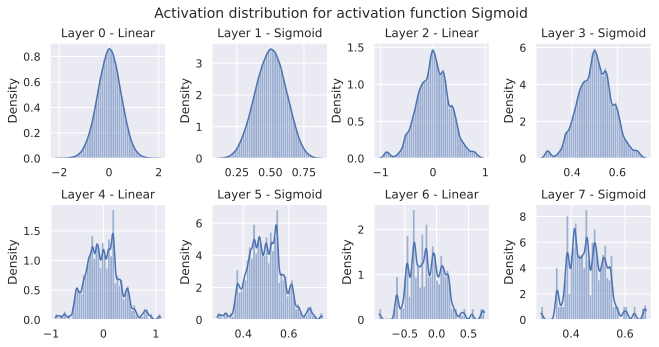

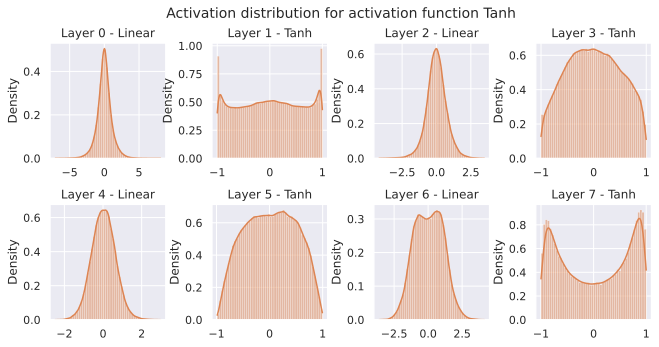

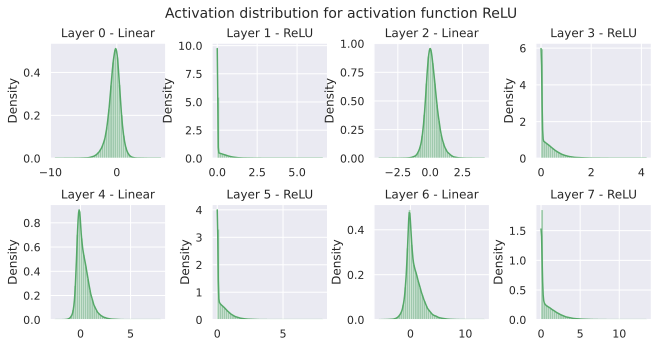

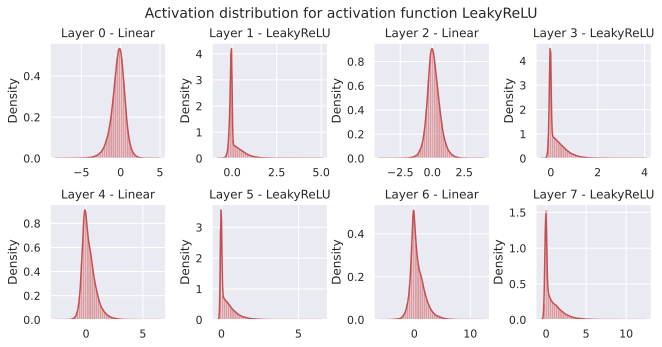

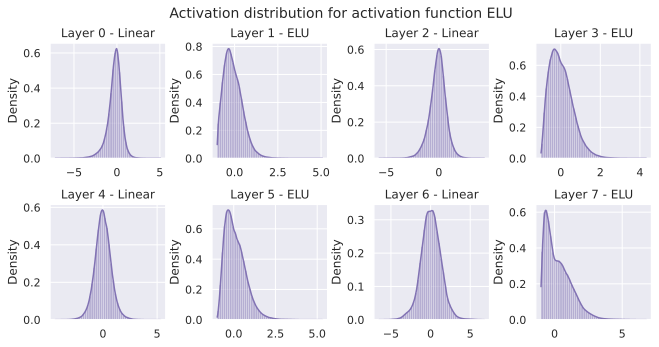

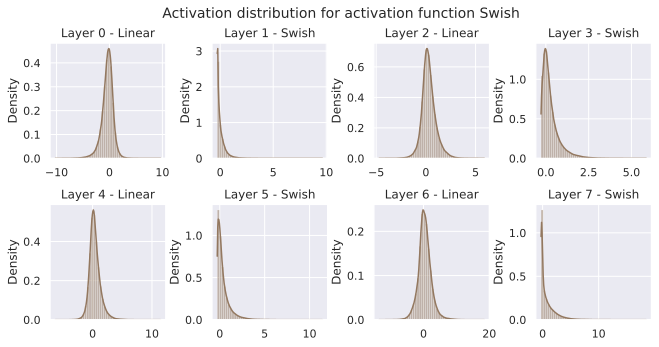

In [68]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}") # 상위 코드에서 만든 index 시각화

    죽은 뉴런의 수 측정

In [69]:
@torch.no_grad() # autograd의 작동을 중지함으로써 메모리 사용량을 줄이고 연산속도를 높이기 위함
def measure_number_dead_neurons(net):
    """Function to measure the number of dead neurons in a trained neural network.

    For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time, we
    set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    """
    neurons_dead = [ # 죽은 뉴런 수 계산 식
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool)
        for layer in net.layers[:-1]
        if isinstance(layer, nn.Linear)
    ]

    net.eval()
    for imgs, labels in tqdm(train_loader, leave=False): # 진행률 확인
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        for layer in net.layers[:-1]:
            imgs = layer(imgs)
            if isinstance(layer, ActivationFunction):
                neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print(
        "In percentage:",
        ", ".join(
            [f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]
        ),
    )

In [70]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


In [71]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 3]
In percentage: 0.00%, 0.00%, 0.00%, 2.34%


In [72]:
set_seed(42)
net_relu = BaseNetwork(
    act_fn=ReLU(),
    hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128],
).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%
